In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv


# For the predictive models
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBSklearn
from sklearn.tree import DecisionTreeClassifier


# Removing annoying warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
def count_by_group(data, feature, target):
    df = data.groupby([feature, target])[target].agg(['count'])
    temp = data.groupby([feature])[target].agg(['count'])
    df['pct'] = 100*df.div(temp, level = feature).reset_index()['count'].values
    return df.reset_index()
def classification_report_to_dataframe(true, predictions, predictions_proba, model_name, balanced = 'no'):
    a = classification_report(true, predictions, output_dict = True)
    zeros = pd.DataFrame(data = a['0'], index = [0]).iloc[:,0:3].add_suffix('_0')
    ones = pd.DataFrame(data = a['1'], index = [0]).iloc[:,0:3].add_suffix('_1')
    df = pd.concat([zeros, ones], axis = 1)
    temp = list(df)
    df['Model'] = model_name
    df['Balanced'] = balanced
    df['Accuracy'] = accuracy_score(true, predictions)
    df['Balanced_Accuracy'] = balanced_accuracy_score(true, predictions)
    df['AUC'] = roc_auc_score(true, predictions_proba, average = 'macro')
    df = df[['Model', 'Balanced', 'Accuracy', 'Balanced_Accuracy', 'AUC'] + temp]
    return df

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
dataset=pd.read_csv("C:/Users/apple/Downloads/churn_prediction_data/churn_prediction_data/train.csv")
test=pd.read_csv("C:/Users/apple/Downloads/churn_prediction_data/churn_prediction_data/test.csv")

In [4]:
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,551,15806307,Trevisano,720,Spain,Male,38,5,114051.97,2,0,1,107577.29,0
1,6897,15709621,Martin,682,France,Female,54,4,62397.41,1,1,0,113088.60,1
2,4588,15619340,Palmer,672,France,Female,31,5,119903.67,1,1,1,132925.17,0
3,291,15620746,Napolitani,592,Spain,Female,40,4,104257.86,1,1,0,110857.33,0
4,1673,15646372,Yao,753,Spain,Male,42,5,120387.73,1,0,1,126378.57,0


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 14 columns):
RowNumber          8000 non-null int64
CustomerId         8000 non-null int64
Surname            8000 non-null object
CreditScore        8000 non-null int64
Geography          8000 non-null object
Gender             8000 non-null object
Age                8000 non-null int64
Tenure             8000 non-null int64
Balance            8000 non-null float64
NumOfProducts      8000 non-null int64
HasCrCard          8000 non-null int64
IsActiveMember     8000 non-null int64
EstimatedSalary    8000 non-null float64
Exited             8000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 875.1+ KB


In [6]:
dataset.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
round(dataset.describe(),3)

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,8000.000,8.000000e+03,8000.000,8000.000,8000.000,8000.000,8000.000,8000.000,8000.000,8000.000,8000.000
mean,5001.027,1.569089e+07,630.805,42.988,4.567,100569.286,1.534,0.703,0.517,100103.555,0.204
std,2879.567,7.187307e+04,59.077,7.516,1.273,31431.772,0.583,0.457,0.500,24511.461,0.403
min,1.000,1.556571e+07,446.000,28.000,2.000,62397.410,1.000,0.000,0.000,57522.070,0.000
25%,2500.750,1.562882e+07,590.000,38.000,4.000,62397.410,1.000,0.000,0.000,79216.925,0.000
50%,5014.000,1.569017e+07,631.000,42.000,5.000,111118.600,1.000,1.000,1.000,100056.110,0.000
75%,7474.250,1.575398e+07,672.000,47.000,6.000,126500.100,2.000,1.000,1.000,121104.543,0.000
max,9999.000,1.581569e+07,753.000,81.000,7.000,188500.680,4.000,1.000,1.000,142481.990,1.000


In [8]:
exited = len(dataset[dataset['Exited'] == 1]['Exited'])
not_exited = len(dataset[dataset['Exited'] == 0]['Exited'])
exited_perc = round(exited/len(dataset)*100,1)
not_exited_perc = round(not_exited/len(dataset)*100,1)

print('Number of clients that have exited the program: {} ({}%)'.format(exited, exited_perc))
print('Number of clients that haven\'t exited the program: {} ({}%)'.format(not_exited, not_exited_perc))

Number of clients that have exited the program: 1632 (20.4%)
Number of clients that haven't exited the program: 6368 (79.6%)


In [9]:
country = list(dataset['Geography'].unique())
gender = list(dataset['Gender'].unique())

print(country)
print(gender)

['Spain', 'France', 'Germany']
['Male', 'Female']


In [10]:
dataset['Exited_str'] = dataset['Exited']
dataset['Exited_str'] = dataset['Exited_str'].map({1: 'Exited', 0: 'Stayed'})

In [11]:
gender_count = dataset['Gender'].value_counts()
gender_pct= gender_count / len(dataset.index)

gender = pd.concat([gender_count, round(gender_pct,2)], axis=1)\
        .set_axis(['count', 'pct'], axis=1, inplace=False)
gender

,count,pct
Male,4371,0.55
Female,3629,0.45


In [12]:
geo_count = dataset['Geography'].value_counts()
geo_pct= geo_count / len(dataset.index)

geo = pd.concat([geo_count, round(geo_pct,2)], axis=1)\
        .set_axis(['count', 'pct'], axis=1, inplace=False)
geo

,count,pct
France,4006,0.50
Germany,2018,0.25
Spain,1976,0.25


In [13]:
def count_by_group(data, feature, target):
    df = data.groupby([feature, target])[target].agg(['count'])
    temp = data.groupby([feature])[target].agg(['count'])
    df['pct'] = 100*df.div(temp, level = feature).reset_index()['count'].values
    return df.reset_index()

In [14]:
count_by_group(dataset, feature = 'Gender', target = 'Exited')

,Gender,Exited,count,pct
0,Female,0,2721,74.979333
1,Female,1,908,25.020667
2,Male,0,3647,83.436285
3,Male,1,724,16.563715


In [15]:
pd.options.display.max_rows = 8
#colorDict = {
#    'Exited':'#f71b1b',
#    'Stayed':'grey',
#    'Female':'#FFD700',
#    'Male':'#8E388E'
#}
#sankey(
#    dataset['Gender'], dataset['Exited_str'], aspect=20, colorDict=colorDict,
#    fontsize=12, figureName="Gender"
#)

In [17]:
count_by_group(dataset, feature = 'Geography', target = 'Exited')

,Geography,Exited,count,pct
0,France,0,3361,83.899151
1,France,1,645,16.100849
2,Germany,0,1369,67.839445
3,Germany,1,649,32.160555
4,Spain,0,1638,82.894737
5,Spain,1,338,17.105263


In [18]:
HasCrCard_count = dataset['HasCrCard'].value_counts()
HasCrCard_pct= HasCrCard_count / len(dataset.index)

HasCrCard = pd.concat([HasCrCard_count, HasCrCard_pct], axis=1)\
        .set_axis(['count', 'pct'], axis=1, inplace=False)

HasCrCard

,count,pct
1,5622,0.70275
0,2378,0.29725


In [19]:
count_by_group(dataset, feature = 'HasCrCard', target = 'Exited')

,HasCrCard,Exited,count,pct
0,0,0,1883,79.184188
1,0,1,495,20.815812
2,1,0,4485,79.775880
3,1,1,1137,20.224120


In [20]:
# Create a HasCrCard string variable to create the plots
dataset['HasCrCard_str'] = dataset['HasCrCard'].map({1: 'Has Credit Card', 0: 'Does not have Credit Card'})

In [21]:
IsActiveMember_count = dataset['IsActiveMember'].value_counts()
IsActiveMember_pct= HasCrCard_count / len(dataset.index)

IsActiveMember = pd.concat([IsActiveMember_count, IsActiveMember_pct], axis=1)\
        .set_axis(['count', 'pct'], axis=1, inplace=False)

IsActiveMember

,count,pct
1,4135,0.70275
0,3865,0.29725


In [22]:
count_by_group(dataset, feature = 'IsActiveMember', target = 'Exited')

,IsActiveMember,Exited,count,pct
0,0,0,2821,72.988357
1,0,1,1044,27.011643
2,1,0,3547,85.779927
3,1,1,588,14.220073


In [23]:
# Create a IsActiveMember string variable to create the plots
dataset['IsActiveMember_str'] = dataset['IsActiveMember'].map({1: 'Is Active Member', 0: 'Is Not ActiveMember'})

In [24]:
NumOfProducts_count = dataset['NumOfProducts'].value_counts()
NumOfProducts_pct= NumOfProducts_count / len(dataset.index)

NumOfProducts = pd.concat([NumOfProducts_count, round(NumOfProducts_pct,2)], axis=1)\
        .set_axis(['count', 'pct'], axis=1, inplace=False)
NumOfProducts

,count,pct
1,4039,0.50
2,3697,0.46
3,215,0.03
4,49,0.01


In [25]:
count_by_group(dataset, feature = 'NumOfProducts', target = 'Exited')

,NumOfProducts,Exited,count,pct
0,1,0,2910,72.047537
1,1,1,1129,27.952463
2,2,0,3422,92.561536
3,2,1,275,7.438464
4,3,0,36,16.744186
5,3,1,179,83.255814
6,4,1,49,100.000000


In [26]:
# Create a IsActiveMember string variable to create the plots
dataset['NumOfProducts_str'] = dataset['NumOfProducts'].map({1: '1', 2: '2', 3: '3', 4: '4'})


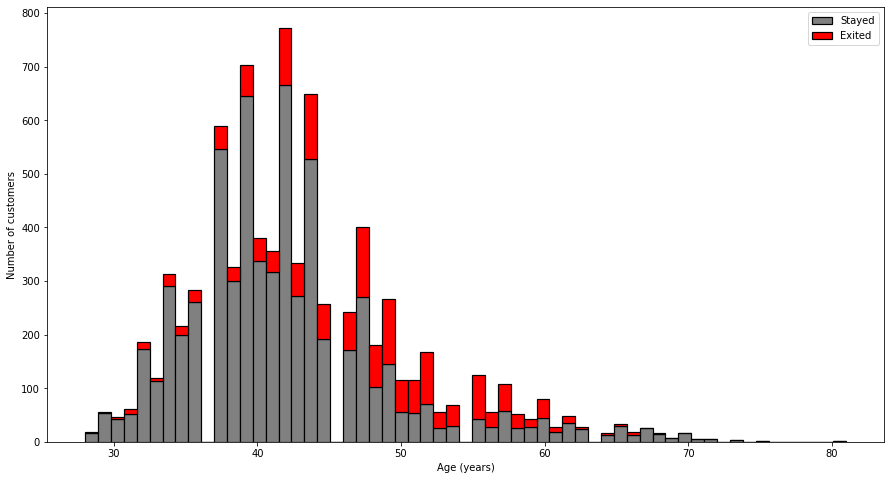

In [27]:
#Stacked histogram: Age
figure = plt.figure(figsize=(15,8))
plt.hist([
        dataset[(dataset.Exited==0)]['Age'],
        dataset[(dataset.Exited==1)]['Age']
        ], 
         stacked=True, color = ['grey','r'],
         bins = 'auto',label = ['Stayed','Exited'],
         edgecolor='black', linewidth=1.2)
plt.xlabel('Age (years)')
plt.ylabel('Number of customers')
plt.legend()

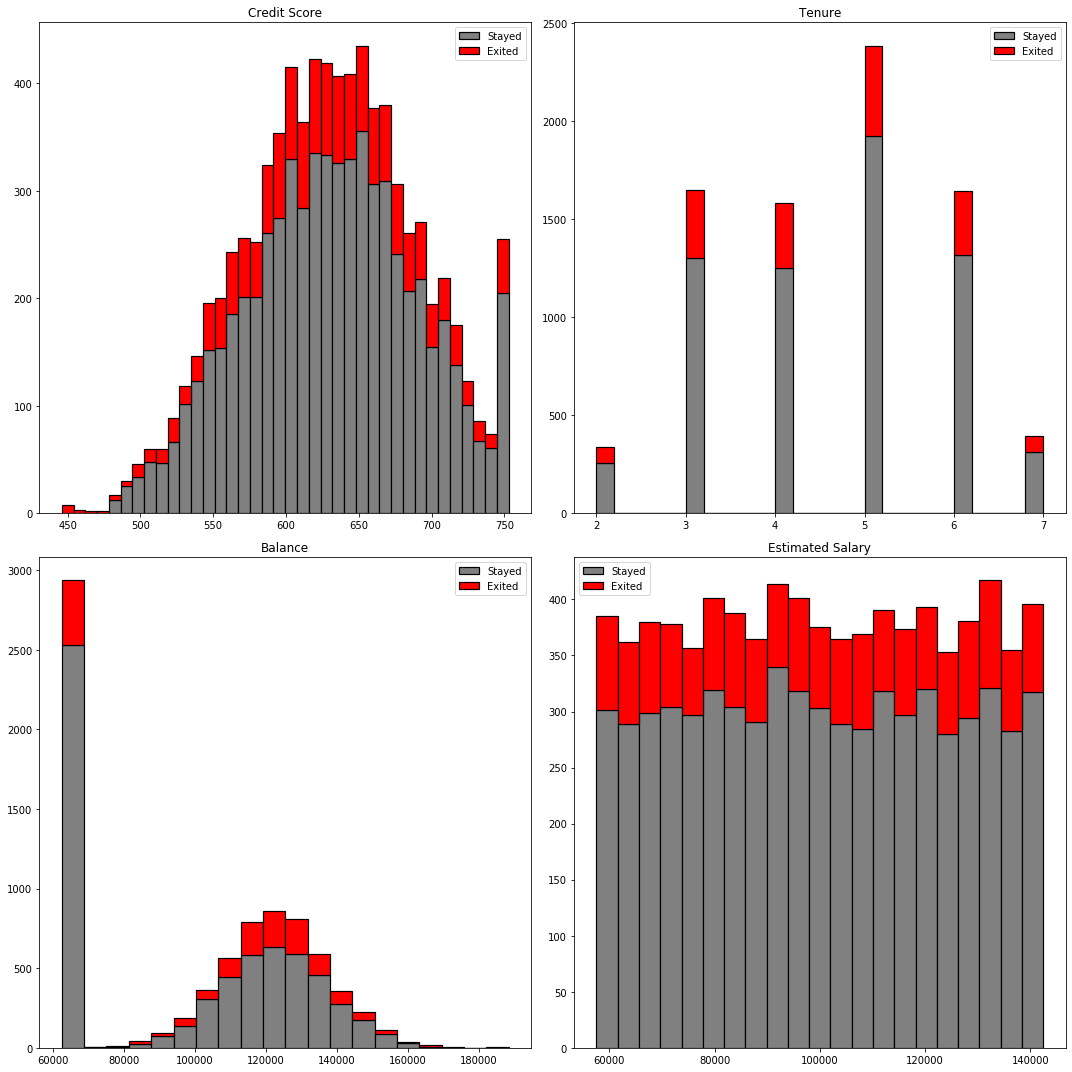

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (15,15))
fig.subplots_adjust(left=0.2, wspace=0.6)
ax0, ax1, ax2, ax3 = axes.flatten()

ax0.hist([
        dataset[(dataset.Exited==0)]['CreditScore'],
        dataset[(dataset.Exited==1)]['CreditScore']
        ], 
         stacked=True, color = ['grey','r'],
         bins = 'auto',label = ['Stayed','Exited'],
         edgecolor='black', linewidth=1.2)
ax0.legend()
ax0.set_title('Credit Score')

ax1.hist([
        dataset[(dataset.Exited==0)]['Tenure'],
        dataset[(dataset.Exited==1)]['Tenure']
        ], 
         stacked=True, color = ['grey','r'],
         bins = 'auto',label = ['Stayed','Exited'],
         edgecolor='black', linewidth=1.2)
ax1.legend()
ax1.set_title('Tenure')

ax2.hist([
        dataset[(dataset.Exited==0)]['Balance'],
        dataset[(dataset.Exited==1)]['Balance']
        ], 
         stacked=True, color = ['grey','r'],
         bins = 'auto',label = ['Stayed','Exited'],
         edgecolor='black', linewidth=1.2)
ax2.legend()
ax2.set_title('Balance')

ax3.hist([
        dataset[(dataset.Exited==0)]['EstimatedSalary'],
        dataset[(dataset.Exited==1)]['EstimatedSalary']
        ], 
         stacked=True, color = ['grey','r'],
         bins = 'auto',label = ['Stayed','Exited'],
         edgecolor='black', linewidth=1.2)
ax3.legend()
ax3.set_title('Estimated Salary')

fig.tight_layout()
plt.show()

In [29]:
# One-Hot encoding our categorical attributes
list_cat = ['Geography', 'Gender']
dataset = pd.get_dummies(dataset, columns = list_cat, prefix = list_cat)
test = pd.get_dummies(test, columns = list_cat, prefix = list_cat)
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,...,Exited,Exited_str,HasCrCard_str,IsActiveMember_str,NumOfProducts_str,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,551,15806307,Trevisano,720,38,5,114051.97,2,0,1,...,0,Stayed,Does not have Credit Card,Is Active Member,2,0,0,1,0,1
1,6897,15709621,Martin,682,54,4,62397.41,1,1,0,...,1,Exited,Has Credit Card,Is Not ActiveMember,1,1,0,0,1,0
2,4588,15619340,Palmer,672,31,5,119903.67,1,1,1,...,0,Stayed,Has Credit Card,Is Active Member,1,1,0,0,1,0
3,291,15620746,Napolitani,592,40,4,104257.86,1,1,0,...,0,Stayed,Has Credit Card,Is Not ActiveMember,1,0,0,1,1,0
4,1673,15646372,Yao,753,42,5,120387.73,1,0,1,...,0,Stayed,Does not have Credit Card,Is Active Member,1,0,0,1,0,1


In [30]:
test.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,2209,15623595,Scott,726,39,3,62397.41,1,0,0,106139.31,1,0,0,1,0
1,9924,15740283,Yegorova,661,42,3,130339.64,1,1,0,125776.38,1,0,0,0,1
2,4617,15802368,Tan,545,34,6,62397.41,2,1,1,78372.28,1,0,0,0,1
3,6077,15615322,Anayochukwu,731,42,3,86717.08,1,1,0,136026.27,0,0,1,1,0
4,9240,15766374,Glover,533,50,6,62397.41,1,1,1,135205.58,1,0,0,1,0


In [31]:
dataset = dataset.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited_str','HasCrCard_str', 'IsActiveMember_str','NumOfProducts_str'], axis = 1)

In [32]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 14 columns):
CreditScore          8000 non-null int64
Age                  8000 non-null int64
Tenure               8000 non-null int64
Balance              8000 non-null float64
NumOfProducts        8000 non-null int64
HasCrCard            8000 non-null int64
IsActiveMember       8000 non-null int64
EstimatedSalary      8000 non-null float64
Exited               8000 non-null int64
Geography_France     8000 non-null uint8
Geography_Germany    8000 non-null uint8
Geography_Spain      8000 non-null uint8
Gender_Female        8000 non-null uint8
Gender_Male          8000 non-null uint8
dtypes: float64(2), int64(7), uint8(5)
memory usage: 601.7 KB


In [33]:
features = list(dataset.drop('Exited', axis = 1))
target = 'Exited'
features

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Geography_France',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Female',
 'Gender_Male']

In [34]:
#train, test = train_test_split(dataset, test_size = 0.2, random_state = 1)
#test=pd.read_csv("C:/Users/apple/Downloads/churn_prediction_data/churn_prediction_data/test.csv")
print('Number of clients in the train set: {}'.format(len(dataset)))
print('Number of clients in the test set: {}'.format(len(test)))
print('Number of clients in the whole set: {}'.format(len(test)+len(dataset)))

Number of clients in the train set: 8000
Number of clients in the test set: 2000
Number of clients in the whole set: 10000


In [35]:
exited_train = len(dataset[dataset['Exited'] == 1]['Exited'])


In [36]:
sc = StandardScaler()
dataset[features] = sc.fit_transform(dataset[features])
dataset[features]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,1.509906,-0.663721,0.339933,0.428978,0.799546,-1.537586,0.966801,0.304927,-1.001501,-0.580814,1.746019,-0.911178,0.911178
1,0.866637,1.465241,-0.445812,-1.214512,-0.917139,0.650370,-1.034339,0.529787,0.998501,-0.580814,-0.572731,1.097481,-1.097481
2,0.697356,-1.595141,0.339933,0.615161,-0.917139,0.650370,0.966801,1.339115,0.998501,-0.580814,-0.572731,1.097481,-1.097481
3,-0.656894,-0.397600,-0.445812,0.117359,-0.917139,0.650370,-1.034339,0.438752,-1.001501,-0.580814,1.746019,1.097481,-1.097481
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7996,-0.487612,0.267700,1.911421,1.440568,-0.917139,0.650370,-1.034339,-0.033763,-1.001501,1.721720,-0.572731,1.097481,-1.097481
7997,0.815853,0.001580,0.339933,1.025801,-0.917139,0.650370,-1.034339,1.251627,-1.001501,-0.580814,1.746019,1.097481,-1.097481
7998,1.425266,-0.663721,-0.445812,0.577801,-0.917139,-1.537586,-1.034339,-0.188456,0.998501,-0.580814,-0.572731,-0.911178,0.911178
7999,-0.521469,-0.131480,0.339933,-1.214512,-0.917139,-1.537586,-1.034339,-1.378566,0.998501,-0.580814,-0.572731,1.097481,-1.097481


In [37]:
test[features] = sc.fit_transform(test[features])
test[features]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,1.609183,-0.508456,-1.222346,-1.272730,-0.889646,-1.589760,-1.016130,0.263584,0.992032,-0.570422,-0.578120,1.090038,-1.090038
1,0.528128,-0.112514,-1.222346,0.915085,-0.889646,0.629026,-1.016130,1.077935,0.992032,-0.570422,-0.578120,-0.917399,0.917399
2,-1.401138,-1.168361,1.184637,-1.272730,0.841183,0.629026,0.984126,-0.887917,0.992032,-0.570422,-0.578120,-0.917399,0.917399
3,1.692341,-0.112514,-1.222346,-0.489610,-0.889646,0.629026,-1.016130,1.502999,-1.008032,-0.570422,1.729744,1.090038,-1.090038
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,0.162233,-0.244495,0.382309,-0.121318,0.841183,0.629026,-1.016130,0.404264,-1.008032,1.753089,-0.578120,-0.917399,0.917399
1997,-1.351243,0.415410,-1.222346,0.552459,0.841183,0.629026,0.984126,0.702602,0.992032,-0.570422,-0.578120,1.090038,-1.090038
1998,-0.453136,0.151448,1.986964,-1.272730,0.841183,0.629026,0.984126,1.175787,-1.008032,-0.570422,1.729744,1.090038,-1.090038
1999,-0.236926,-1.432322,0.382309,0.117487,-0.889646,0.629026,-1.016130,0.180685,-1.008032,1.753089,-0.578120,1.090038,-1.090038


In [40]:
clf = DecisionTreeClassifier()
data_clf = clf.fit(dataset[features], dataset["Exited"])

In [41]:
test_predicted_clf = data_clf.predict(test[features])
test_predicted_clf

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [42]:
upload=pd.read_csv("C:/Users/apple/Downloads/churn_prediction_data/churn_prediction_data/upload.csv")
upload_clf=upload
upload_clf["Exited"]=test_predicted_clf
upload_clf.to_csv("C:/Users/apple/Downloads/churn_prediction_data/churn_prediction_data/upload_clf.csv")

PermissionError: [Errno 13] Permission denied: 'C:/Users/apple/Downloads/churn_prediction_data/churn_prediction_data/upload_clf.csv'

In [78]:
from sklearn import  ensemble, preprocessing, metrics
rdf=ensemble.RandomForestClassifier(n_estimators = 100)
rdf_fit = rdf.fit(dataset[features], dataset["Exited"])

In [79]:
test_predicted_rdf = rdf_fit.predict(test[features])
test_predicted_rdf

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [80]:
upload=pd.read_csv("C:/Users/apple/Downloads/churn_prediction_data/churn_prediction_data/upload.csv")
upload_rdf=upload
upload_rdf["Exited"]=test_predicted_rdf
upload_rdf.to_csv("C:/Users/apple/Downloads/churn_prediction_data/churn_prediction_data/upload_rdf.csv")

In [82]:
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
gnb_fit=gnb.fit(dataset[features], dataset["Exited"])
GaussianNB(priors=None)

GaussianNB(priors=None, var_smoothing=1e-09)

In [83]:
test_predicted_gnb = gnb_fit.predict(test[features])
test_predicted_gnb

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [84]:
upload=pd.read_csv("C:/Users/apple/Downloads/churn_prediction_data/churn_prediction_data/upload.csv")
upload_gnb=upload
upload_gnb["Exited"]=test_predicted_gnb
upload_gnb.to_csv("C:/Users/apple/Downloads/churn_prediction_data/churn_prediction_data/upload_gnb.csv")